<a href="https://colab.research.google.com/github/papagorgio23/Python101/blob/master/Refresh_NPV_(8_10_20).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import joblib
import json
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# set working directory
import os
os.chdir("/content/drive/My Drive/Data Scientist/F+ Lead Scoring Model/bitBucket/fuse-fplus-lead-scoring/")
os.getcwd()


'/content/drive/My Drive/Data Scientist/F+ Lead Scoring Model/bitBucket/fuse-fplus-lead-scoring'

In [ ]:
ls

 bitbucket-pipelines.yml          NPV_Twintiles.csv
 Data/                            README.md
 final.csv                       'Refresh NPV (8-10-20).ipynb'
 Fplus_Lead_Scoring               requirements.txt
 Fplus_Lead_Scoring_new           schema.json
 LeadScoringModel_Twintiles.csv   score_collector_phase1.py
 library_binning.py               scoringData.py
 main_leadLevel.py                test_data.json
 model.py                         validation.csv


## Load Data

In [ ]:
fplus_ls_model = joblib.load('Fplus_Lead_Scoring_new')
# fplus_ls_model = model
unitEconomicsData = pd.read_csv('Data/unitEconomicsData.csv')
training = pd.read_csv('Data/Refresh_NPV.csv')

## Library Binning

In [ ]:
import numpy as np
import pandas as pd

def get_co_app_cat(co_app_income):
    
    if pd.isnull(co_app_income):
        return 0
    if float(co_app_income) == 0:
        return 0
    return 1

def get_loan_use_cat(loan_use):
    if pd.isnull(loan_use):
        return 0
    
    loan_use = loan_use.lower().strip()
    if (loan_use in ['major purchase',
                     'other',
                     'Business Expenses',
                     'Medical Expenses',
                     'auto purchase']):
        return 1
    
    return 0

def get_employment_cat(employment_status):
    
    if pd.isnull(employment_status):
        employment_status = ''
    
    employment_status = employment_status.lower().strip()

    if (employment_status in ['self-employed', 'other']):
        return 1
    if (employment_status in ['retired', 'not employed']):
        return 3
    
    return 2

def get_loan_amount_cat(loan_amount):
    
    if pd.isnull(loan_amount):
        return 5
    
    loan_amount = float(loan_amount)
    if (loan_amount < 10000):
        return 1
    if (loan_amount >= 10000) and (loan_amount < 12500):
        return 2
    if (loan_amount >= 12500) and (loan_amount < 20000):
        return 3
    if (loan_amount >= 20000) and (loan_amount < 35000):
        return 4
    if (loan_amount >= 40000) and (loan_amount < 55000):
        return 4
    
    return 5

def get_mkt_chan_cat(utm_source):
    
    if pd.isnull(utm_source):
        return np.exp(5)
    
    utm_source = utm_source.lower().strip()
    if (utm_source in ['google', 'website', 'ck']):
        return np.exp(6)
    if (utm_source in ['ibm']):
        return np.exp(4)
    if (utm_source in ['even', 'nerdwallet', 'Shogun']):
        return np.exp(3)
    if (utm_source in ['credible']):
        return np.exp(2)
    if (utm_source in ['bkr', 'creditkarma']):
        return np.exp(1)
    
    return np.exp(5)

def get_fico(fico):
    
    if pd.isnull(fico):
        fico = 900
    
    fico = int(fico)
    if (fico >= 9000):
        fico = 900
    if fico < 620:
        fico = 900
    
    ficofloor = 1/(np.floor(fico/10)*10)
    ficosig = np.exp(ficofloor)/(1+np.exp(ficofloor))

    return ficosig

def get_lti(lti):
    
    if pd.isnull(lti):
        return 0.36

    lti = np.floor((lti * 100)/5)*5
    
    # lti = float(lti)
    if (lti >= 45):
        return 45
    if (lti <= 10):
        return 5
    
    return np.floor(lti)

def get_bcc0300(bcc0300):
    
    if pd.isnull(bcc0300):
        return 99
    
    bcc0300 = int(bcc0300)
    if (bcc0300 >= 25):
        return 30
    
    return bcc0300

def get_ndi_cat(ndi_cat):
    
    if pd.isnull(ndi_cat):
        return 1
    
    ndi_cat = float(ndi_cat)
    ndi_cat = np.floor((ndi_cat * 100)/5)*5
    
    if (ndi_cat >= 70):
        return 1
    if (ndi_cat >= 50) and (ndi_cat < 70):
        return 2
    if (ndi_cat >= 0) and (ndi_cat < 25):
        return 4
    
    return 3  


## Main Lead

In [ ]:

def main_leadlevel(leads, phase=1, provide="scored_lead"):
    
    if phase == 1:
        checked_lead = check_lead_phase1(leads)
        
        if checked_lead["error"]:
            return_value = {
                "fuse.score" : 0,
                "fuse.npv" : 0,
                "fuse.model" : '',
                "fuse.error_flag": True,
                "fuse_error_reason" : "Lead Validation Failed."
            }
            return return_value
        error_msg = checked_lead["warning"]
        
        return_value = score_collector_phase1(checked_lead["return_lead"])
        if len(error_msg.strip()) > 0:
            return_value['fuse.error_reason'] = error_msg + ' ' + return_value['fuse.error_reason']
        
        return return_value

# Check that the lead has all the required fields
# if a value is missing, return warning message
def check_lead_phase1(lead):
    
    # convert all keys to lower case
    raw_lead = {k.lower(): v for k, v in lead.items()}
    
    error = False
    return_lead = {}
    missing_variables = []
    error_msg = ''
    
    required_fields = ["co_app_verifiable_annual_income","loan_use","employment_status",
                       "final_loan_amount","fico","lti","xpn_bcc0300","ndi_ratio","utm_source"]

    try:
        for field in required_fields:
            if (field not in raw_lead):
                raw_lead[field] = np.NaN
        
        for key in raw_lead:
            var = returnNaNifEmptyorNaN(raw_lead[key])
            return_lead[key] = var
            if (pd.isnull(return_lead[key])):
                missing_variables.append(key) 
        
        if (len(missing_variables)>0):
            error_msg = ",".join(missing_variables)
            error_msg = "Imputing values for: " + error_msg
            
    except Exception as e: 
        #print(e)
        error=True
    
    return_value = {
        "return_lead" : return_lead,
        "warning": error_msg,
        "error": error
    }
    
    return return_value

def returnNaNifEmptyorNaN(variable):
    
    if isinstance(variable, int):
        return variable
    if isinstance(variable, float):
        return variable
    # if null or empty
    if pd.isnull(variable) or len(variable)<1:
        return np.NaN
    if variable.isnumeric():
        return variable

    return variable.strip()


## Score Collector

In [ ]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

#from . import library_binning as lib
#from . import scoringData as sd

def score_collector_phase1(lead, debug = False):
    
    mod_lead = pd.DataFrame()
    bin_vars = {}
    error = False
    error_msg = ''
    prob_prediction = 0
    npv = 0
    MODEL_NAME = 'fplus_ls_202008_v1'
    
    try:
        # create binned/transformed variables
        bin_vars['co_app'] = pd.Series(get_co_app_cat(lead['co_app_verifiable_annual_income']))
        bin_vars['loan_use'] = get_loan_use_cat(lead['loan_use'])
        bin_vars['employment'] = get_employment_cat(lead['employment_status'])
        bin_vars['loan_amount'] = get_loan_amount_cat(lead['final_loan_amount'])
        bin_vars['mkt_chan'] = get_mkt_chan_cat(lead['utm_source'])
        bin_vars['ficox'] = get_fico(lead['fico'])
        bin_vars['lti'] = get_lti(lead['lti'])
        bin_vars['bcc0300'] = get_bcc0300(lead['xpn_bcc0300'])
        bin_vars['ndi'] = get_ndi_cat(lead['ndi_ratio'])
        
        mod_lead = pd.DataFrame(bin_vars)
        
        # create dummies
        cat_vars=['employment','loan_amount', 'ndi']
        for var in cat_vars:
            cat_list = pd.get_dummies(mod_lead[var], prefix=var)
            temp=mod_lead.join(cat_list)
            mod_lead=temp
        data_vars=mod_lead.columns.values.tolist()
        to_keep=[i for i in data_vars if i not in cat_vars]
        mod_lead=mod_lead[to_keep]
        print(mod_lead.columns.values)
        
        # re-index to have same columns as the model
        mod_lead = mod_lead.reindex(columns = ['ficox', 'lti', 'bcc0300', 'co_app',
                                               'loan_use', 'employment_1',
                                               'employment_2', 'employment_3', 'loan_amount_1',
                                               'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 
                                               'loan_amount_5', 'mkt_chan', 'ndi_1', 'ndi_2',
                                               'ndi_3', 'ndi_4',], fill_value=0)
        
        # score
        prob_prediction = fplus_ls_model.predict_proba(mod_lead)[0][1]
        print(prob_prediction)
        
        # calc NPV
        npv = get_npv_calc(lead['final_loan_amount'], prob_prediction, lead['utm_source'])
        
    except Exception as e:
        # print(e)
        error = True
        error_msg = 'Error in Scoring.'
    
    # add an error flag
    if (debug):
        return_scores = {
            'bin_lead': mod_lead,
            'fuse.score':prob_prediction,
            'fuse.npv': npv,
            'fuse.model': MODEL_NAME,
            'fuse.error_flag': error,
            'fuse.error_reason': error_msg
        }
        return return_scores
    
    # return the dictionary
    return_scores = {
        'fuse.score':prob_prediction,
        'fuse.npv': npv,
        'fuse.model': MODEL_NAME,
        'fuse.error_flag': error,
        'fuse.error_reason': error_msg
    }
    return return_scores


def get_npv_calc(loan_amt,prob_prediction,utm_source):
    
    if pd.notnull(utm_source):
        utm_src = utm_source.strip()
        utm_src = utm_src.lower()
    
    npv = 0
    cpa = 0
    
    if pd.notnull(utm_source) and (utm_src in set(unitEconomicsData['utm_source'])):
        cpa = unitEconomicsData.loc[unitEconomicsData['utm_source'] == utm_src, 'CPA'].values[0]
                
    if pd.isnull(loan_amt):
        loan_amt = 0
    else:
        loan_amt = float(loan_amt) 
        
    npv = prob_prediction * ((loan_amt * 0.0681) - (621 + cpa))
    
    return npv

## Scoring Data

In [ ]:
import numpy as np
import pandas as pd
import logging
import os
from sklearn.externals import joblib


dirdata = os.path.join(os.path.dirname(__file__), 'Data')

global initialized
initialized = False

def init():
    
    global fplus_ls_model
    global unitEconomicsData
    
    global initialized
    if (initialized == True):
        return
    
    try:
        #fplus_ls_model = joblib.load('Data/Fplus_Lead_Scoring')
        #unitEconomicsData = pd.read_csv('Data/unitEconomicsData.csv')
        fplus_ls_model = joblib.load(os.path.join(dirdata, 'Fplus_Lead_Scoring'))
        unitEconomicsData = pd.read_csv(os.path.join(dirdata, 'unitEconomicsData.csv'))
        
    except Exception as e:
        #print(e)
        return
    
    initialized = True



## Model

In [ ]:

# from . import scoringData as sd
# from . import main_leadLevel as ml
import pandas as pd
import json

# init()

# Assumption : gets dictionary as a input
def run(leads):
    score = main_leadlevel(leads)
    #score is dictionary, score['fuse_score'] is dataframe
    
    #add scores to the lead
    if ('co_app_verifiable_annual_income' in leads):
        leads['co_app_verifiable_annual_income']=str(leads['co_app_verifiable_annual_income'])
    if ('fico' in leads):
        leads['fico']=str(leads['fico'])
    if ('LTI' in leads):
        leads['LTI']=str(leads['LTI'])
    if ('xpn_bcc0300' in leads):
        leads['xpn_bcc0300']=str(leads['xpn_bcc0300'])
    if ('ndi_ratio' in leads):
        leads['ndi_ratio']=str(leads['ndi_ratio'])
    if ('final_loan_amount' in leads):
        leads['final_loan_amount']=str(leads['final_loan_amount'])
    leads.update(score)
    
    return_list = []
    return_list.append(leads)
    return return_list

def format_scores_returned(score):

    # convert everything to a dataframe
    score = pd.DataFrame.from_dict(score,orient='index').transpose() 
    
    # convert back to dictionary in list format
    score = score.to_dict('list')
    
    return score



## Load Data

In [ ]:
training.head()

,name,funded_flag,first_coapp,first_loan_use,employment_status__c,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c,utm_source__c
0,App-07278314,0,1,Debt Consolidation,Self-employed,40000,697.0,0.210526,7,0.218200,Lending Tree
1,App-07278317,0,0,Debt Consolidation,Full-time,15000,687.0,0.245467,5,0.575611,Lending Tree
2,App-07278321,0,0,Other,Full-time,11000,734.0,0.192982,3,0.474172,Lending Tree
3,App-07278324,0,0,Debt Consolidation,Full-time,10000,673.0,0.106383,18,0.427942,Lending Tree
4,App-07278325,0,0,Debt Consolidation,Full-time,13000,683.0,0.351351,4,0.699950,credible


In [ ]:
training.isna().sum()

name                                0
funded_flag                         0
first_coapp                         0
first_loan_use                      0
employment_status__c                0
first_amount_of_loan_requested      0
first_FICO                        216
First_LTI                           0
first_bcc0300__c                    0
first_ndi_ratio__c                798
utm_source__c                       0
co_app                              0
loan_use                            0
employment                          0
loan_amount                         0
mkt_chan                            0
ficox                               0
lti                                 0
bcc0300                             0
ndi                                 0
dtype: int64

In [ ]:
first_df = training

## Transform Data

In [ ]:
# Transform variables
first_df['co_app'] = first_df['first_coapp'].apply(get_co_app_cat)
first_df['loan_use'] = first_df['first_loan_use'].apply(get_loan_use_cat)
first_df['employment'] = first_df['employment_status__c'].apply(get_employment_cat)
first_df['loan_amount'] = first_df['first_amount_of_loan_requested'].apply(get_loan_amount_cat)
first_df['mkt_chan'] = first_df['utm_source__c'].apply(get_mkt_chan_cat)
first_df['ficox'] = first_df['first_FICO'].apply(get_fico)
first_df['lti'] = first_df['First_LTI'].apply(get_lti)
first_df['bcc0300'] = first_df['first_bcc0300__c'].apply(get_bcc0300)
first_df['ndi'] = first_df['first_ndi_ratio__c'].apply(get_ndi_cat)


In [ ]:
first_df.head()

,name,funded_flag,first_coapp,first_loan_use,employment_status__c,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c,utm_source__c,co_app,loan_use,employment,loan_amount,mkt_chan,ficox,lti,bcc0300,ndi
0,App-07278314,0,1,Debt Consolidation,Self-employed,40000,697.0,0.210526,7,0.218200,Lending Tree,1,0,1,4,148.413159,0.500362,20.0,7,4
1,App-07278317,0,0,Debt Consolidation,Full-time,15000,687.0,0.245467,5,0.575611,Lending Tree,0,0,2,3,148.413159,0.500368,20.0,5,2
2,App-07278321,0,0,Other,Full-time,11000,734.0,0.192982,3,0.474172,Lending Tree,0,1,2,2,148.413159,0.500342,15.0,3,3
3,App-07278324,0,0,Debt Consolidation,Full-time,10000,673.0,0.106383,18,0.427942,Lending Tree,0,0,2,2,148.413159,0.500373,5.0,18,3
4,App-07278325,0,0,Debt Consolidation,Full-time,13000,683.0,0.351351,4,0.699950,credible,0,0,2,3,7.389056,0.500368,35.0,4,2


In [ ]:
first_df.describe()

,funded_flag,first_coapp,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c,co_app,loan_use,employment,loan_amount,mkt_chan,ficox,lti,bcc0300,ndi
count,103743.000000,103743.000000,103743.000000,103527.000000,103743.000000,103743.000000,102945.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000
mean,0.040494,0.115256,23710.573803,726.259749,0.237115,7.694794,0.375197,0.115256,0.144145,1.917373,3.499446,102.224928,0.500349,20.102368,7.672566,2.967458
std,0.197116,0.319332,11570.120763,177.397152,0.128038,5.410631,0.143199,0.319332,0.351238,0.397037,0.942638,81.326662,0.000024,11.612246,5.154312,0.676032
min,0.000000,0.000000,7500.000000,444.000000,0.000100,0.000000,0.000274,0.000000,0.000000,1.000000,1.000000,2.718282,0.500278,5.000000,0.000000,1.000000
25%,0.000000,0.000000,15000.000000,687.000000,0.152174,4.000000,0.275163,0.000000,0.000000,2.000000,3.000000,20.085537,0.500333,15.000000,4.000000,3.000000
50%,0.000000,0.000000,20000.000000,720.000000,0.213320,7.000000,0.363597,0.000000,0.000000,2.000000,4.000000,148.413159,0.500347,20.000000,7.000000,3.000000
75%,0.000000,0.000000,31000.000000,756.000000,0.291262,10.000000,0.464329,0.000000,0.000000,2.000000,4.000000,148.413159,0.500368,25.000000,10.000000,3.000000
max,1.000000,1.000000,240000.000000,9003.000000,6.000000,99.000000,6.482106,1.000000,1.000000,3.000000,5.000000,403.428793,0.500403,45.000000,30.000000,4.000000


In [ ]:
model1.coef_

array([[-0.74025928, -0.02861992, -0.03581564,  0.46292578, -0.35394426,
        -1.48917067, -0.4596037 ,  0.46876942, -0.35258451, -0.03900395,
        -0.14206332, -0.37961209, -0.56674107,  0.00521273,  0.0113929 ,
        -0.53440934, -0.36689694, -0.59009156]])

## Check inputs

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df1 = first_df
df1.isna().sum()

name                                0
funded_flag                         0
first_coapp                         0
first_loan_use                      0
employment_status__c                0
first_amount_of_loan_requested      0
first_FICO                        216
First_LTI                           0
first_bcc0300__c                    0
first_ndi_ratio__c                798
utm_source__c                       0
co_app                              0
loan_use                            0
employment                          0
loan_amount                         0
mkt_chan                            0
ficox                               0
lti                                 0
bcc0300                             0
ndi                                 0
dtype: int64

### Funded

In [ ]:
# percent of data that has funded or not
df1['funded_flag'].value_counts()/len(df1)

0    0.959506
1    0.040494
Name: funded_flag, dtype: float64

### Co App

[Text(0.5, 0, '')]

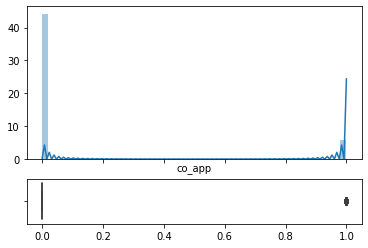

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(df1['co_app'], ax=ax_box)
sns.distplot(df1['co_app'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [ ]:
# percent of data that has funded or not
df1['co_app'].value_counts()/len(df1)

0    0.884744
1    0.115256
Name: co_app, dtype: float64

### Marketing Channel

In [ ]:
np.exp(5)

148.4131591025766

[Text(0.5, 0, '')]

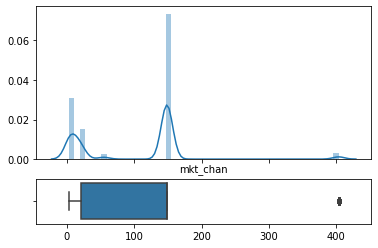

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(df1['mkt_chan'], ax=ax_box)
sns.distplot(df1['mkt_chan'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [ ]:
# percent of data that has funded or not
df1['mkt_chan'].value_counts()/len(df1)

148.413159    0.589514
7.389056      0.163307
20.085537     0.120124
2.718282      0.083206
403.428793    0.024349
54.598150     0.019500
Name: mkt_chan, dtype: float64

### FICO Sig

[Text(0.5, 0, '')]

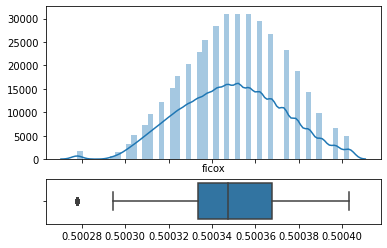

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(df1['ficox'], ax=ax_box)
sns.distplot(df1['ficox'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [ ]:
# percent of data that has funded or not
df1['ficox'].value_counts()/len(df1)

0.500347    0.077914
0.500357    0.077846
0.500352    0.077779
0.500362    0.073827
0.500342    0.071436
0.500368    0.066944
0.500338    0.063792
0.500373    0.058481
0.500333    0.057324
0.500329    0.051107
0.500379    0.047319
0.500325    0.044736
0.500321    0.037882
0.500385    0.036012
0.500316    0.030508
0.500391    0.024599
0.500312    0.024252
0.500309    0.018449
0.500397    0.016907
0.500305    0.012811
0.500403    0.012541
0.500301    0.007837
0.500278    0.004174
0.500298    0.003865
0.500294    0.001658
Name: ficox, dtype: float64

### Employment

In [ ]:
# percent of data that has funded or not
df1['employment'].value_counts()/len(df1)

2    0.835536
1    0.123546
3    0.040918
Name: employment, dtype: float64

### LTIX

[Text(0.5, 0, '')]

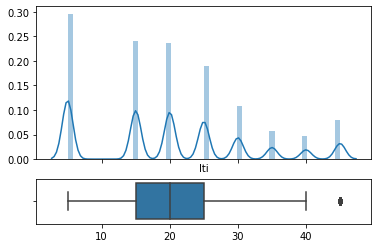

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(df1['lti'], ax=ax_box)
sns.distplot(df1['lti'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [ ]:
# percent of data that has funded or not
df1['lti'].value_counts()/len(df1)

5.0     0.236845
15.0    0.191859
20.0    0.188312
25.0    0.151480
30.0    0.085847
45.0    0.062925
35.0    0.045863
40.0    0.036870
Name: lti, dtype: float64

### BCC

[Text(0.5, 0, '')]

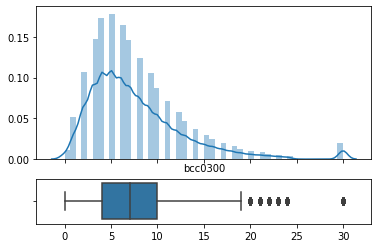

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(df1['bcc0300'], ax=ax_box)
sns.distplot(df1['bcc0300'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

### Loan Cat

[Text(0.5, 0, '')]

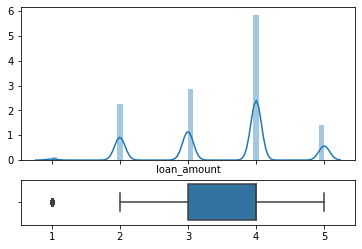

In [ ]:
# Cut the window in 2 parts
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .25)})

# Add a graph in each part
sns.boxplot(df1['loan_amount'], ax=ax_box)
sns.distplot(df1['loan_amount'], ax=ax_hist)

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [ ]:
# percent of data that has funded or not
df1['loan_amount'].value_counts()/len(df1)

4    0.468648
3    0.229134
2    0.179839
5    0.113849
1    0.008531
Name: loan_amount, dtype: float64

### Loan Use

In [ ]:
# percent of data that has funded or not
df1['loan_use'].value_counts()/len(df1)

0    0.855855
1    0.144145
Name: loan_use, dtype: float64

### NDI Cat

In [ ]:
# percent of data that has funded or not
df1['ndi'].value_counts()/len(df1)

3    0.622577
4    0.185882
2    0.164657
1    0.026884
Name: ndi, dtype: float64

# TRAIN MODEL

## Dummy Var

In [ ]:
training.columns

Index(['name', 'funded_flag', 'first_coapp', 'first_loan_use',
       'employment_status__c', 'first_amount_of_loan_requested', 'first_FICO',
       'First_LTI', 'first_bcc0300__c', 'first_ndi_ratio__c', 'utm_source__c',
       'co_app', 'loan_use', 'employment', 'loan_amount', 'mkt_chan', 'ficox',
       'lti', 'bcc0300', 'ndi'],
      dtype='object')

In [ ]:
things = ['funded_flag', 'co_app', 'loan_use', 'mkt_chan', 'ficox', 'employment', 'lti', 'bcc0300', 'loan_amount', 'ndi']
mod_lead = training[things]
mod_lead.head()

,funded_flag,co_app,loan_use,mkt_chan,ficox,employment,lti,bcc0300,loan_amount,ndi
0,0,1,0,148.413159,0.500362,1,20.0,7,4,4
1,0,0,0,148.413159,0.500368,2,20.0,5,3,2
2,0,0,1,148.413159,0.500342,2,15.0,3,2,3
3,0,0,0,148.413159,0.500373,2,5.0,18,2,3
4,0,0,0,7.389056,0.500368,2,35.0,4,3,2


In [ ]:
# create dummies
cat_vars=['employment','loan_amount', 'ndi']
for var in cat_vars:
    cat_list = pd.get_dummies(mod_lead[var], prefix=var)
    temp=mod_lead.join(cat_list)
    mod_lead=temp
data_vars=mod_lead.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
mod_lead=mod_lead[to_keep]
print(mod_lead.columns.values)

# re-index to have same columns as the model
mod_lead = mod_lead.reindex(columns = ['funded_flag', 'ficox', 'lti', 'bcc0300', 'co_app',
                               'loan_use', 'employment_1',
                               'employment_2', 'employment_3', 'loan_amount_1',
                               'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 
                               'loan_amount_5', 'mkt_chan', 'ndi_1', 'ndi_2',
                               'ndi_3', 'ndi_4',], fill_value=0)

['funded_flag' 'co_app' 'loan_use' 'mkt_chan' 'ficox' 'lti' 'bcc0300'
 'employment_1' 'employment_2' 'employment_3' 'loan_amount_1'
 'loan_amount_2' 'loan_amount_3' 'loan_amount_4' 'loan_amount_5' 'ndi_1'
 'ndi_2' 'ndi_3' 'ndi_4']


In [ ]:
mod_lead.describe()

,funded_flag,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4
count,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000,103743.000000
mean,0.040494,0.500349,20.102368,7.672566,0.115256,0.144145,0.123546,0.835536,0.040918,0.008531,0.179839,0.229134,0.468648,0.113849,102.224928,0.026884,0.164657,0.622577,0.185882
std,0.197116,0.000024,11.612246,5.154312,0.319332,0.351238,0.329064,0.370698,0.198102,0.091967,0.384055,0.420277,0.499019,0.317629,81.326662,0.161744,0.370872,0.484744,0.389014
min,0.000000,0.500278,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.718282,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500333,15.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.085537,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.500347,20.000000,7.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,148.413159,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.500368,25.000000,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,148.413159,0.000000,0.000000,1.000000,0.000000
max,1.000000,0.500403,45.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,403.428793,1.000000,1.000000,1.000000,1.000000


In [ ]:
mod_lead.isna().sum()

funded_flag      0
ficox            0
lti              0
bcc0300          0
co_app           0
loan_use         0
employment_1     0
employment_2     0
employment_3     0
loan_amount_1    0
loan_amount_2    0
loan_amount_3    0
loan_amount_4    0
loan_amount_5    0
mkt_chan         0
ndi_1            0
ndi_2            0
ndi_3            0
ndi_4            0
dtype: int64

## Train and Save Model

In [ ]:
# segment out the variable we are predicting from the rest of the data
y = mod_lead['funded_flag']
X = mod_lead.drop(['funded_flag'], axis = 1)
print(X.shape, y.shape)

(103743, 18) (103743,)


In [ ]:
# Split the data into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(82994, 18) (82994,)
(20749, 18) (20749,)


#### Scale data?

In [ ]:
# Set classes for all plots
classes = ['Not Funded', 'Funded']

classifier = LogisticRegression()

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(classifier, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


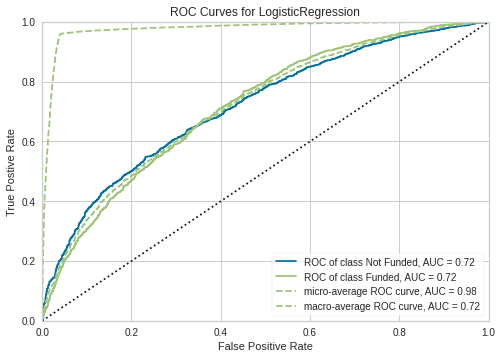

In [ ]:
# Set classes for all plots
classes = ['Not Funded', 'Funded']

classifier = LogisticRegression()

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(classifier, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression

In [ ]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)
model1.score(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9595643163525953

In [ ]:
y_pred = model1.predict_proba(X_test)[:,1]
y_pred

array([0.04975691, 0.03341284, 0.01986552, ..., 0.08300798, 0.05461634,
       0.02783511])

## Prediction

In [ ]:
mod_lead1 = mod_lead

In [ ]:
mod_lead1['y_pred_bal'] = model.predict_proba(X)[:,1]
mod_lead1['y_pred'] = model1.predict_proba(X)[:,1]
mod_lead1.head()

,funded_flag,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4,y_pred_bal,y_pred
0,0,0.500362,20.0,7,1,0,1,0,0,0,0,0,1,0,148.413159,0,0,0,1,0.308208,0.019734
1,0,0.500368,20.0,5,0,0,0,1,0,0,0,1,0,0,148.413159,0,1,0,0,0.567008,0.048615
2,0,0.500342,15.0,3,0,1,0,1,0,0,1,0,0,0,148.413159,0,0,1,0,0.592596,0.055065
3,0,0.500373,5.0,18,0,0,0,1,0,0,1,0,0,0,148.413159,0,0,1,0,0.620056,0.060670
4,0,0.500368,35.0,4,0,0,0,1,0,0,0,1,0,0,7.389056,0,1,0,0,0.243025,0.016261


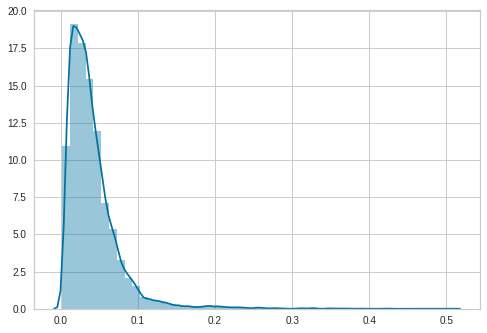

In [ ]:
# distribution of probabilities that model is outputting
sns.distplot(y_pred)

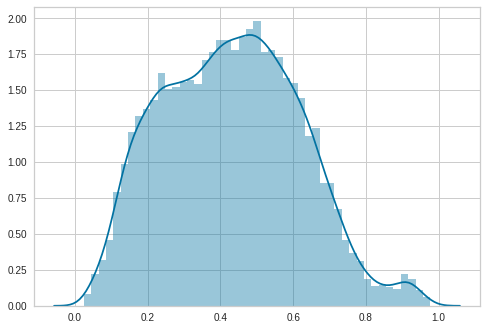

In [ ]:
y_pred = model.predict_proba(X_test)[:,1]
y_pred
# distribution of probabilities that model is outputting
sns.distplot(y_pred)

In [ ]:
# breakout predicted probabilities into deciles
twintiles = np.percentile(mod_lead1['y_pred'], np.arange(0,100,5))
twintiles

array([0.00085635, 0.00841186, 0.01117145, 0.01374699, 0.01628707,
       0.01892493, 0.02145633, 0.02420422, 0.02704072, 0.02981629,
       0.03252398, 0.03572741, 0.03897772, 0.04246567, 0.04693785,
       0.05165209, 0.0572117 , 0.06516999, 0.07604856, 0.09636631])

In [ ]:
mod_lead

,funded_flag,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4
0,0,0.500362,20.0,7,1,0,1,0,0,0,0,0,1,0,148.413159,0,0,0,1
1,0,0.500368,20.0,5,0,0,0,1,0,0,0,1,0,0,148.413159,0,1,0,0
2,0,0.500342,15.0,3,0,1,0,1,0,0,1,0,0,0,148.413159,0,0,1,0
3,0,0.500373,5.0,18,0,0,0,1,0,0,1,0,0,0,148.413159,0,0,1,0
4,0,0.500368,35.0,4,0,0,0,1,0,0,0,1,0,0,7.389056,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103738,0,0.500357,15.0,5,0,1,0,1,0,0,0,0,1,0,148.413159,0,0,1,0
103739,0,0.500325,5.0,7,0,0,0,1,0,0,0,0,1,0,148.413159,0,0,1,0
103740,0,0.500342,15.0,5,0,0,0,1,0,0,0,1,0,0,148.413159,0,0,1,0
103741,0,0.500385,20.0,18,0,0,0,1,0,0,0,1,0,0,148.413159,0,0,1,0


In [ ]:
X['y_pred'] = fplus_ls_model.predict_proba(X)[:,1]

In [ ]:
final = X
final['funded_flag'] = y
final.head()

,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4,y_pred,funded_flag
0,0.500362,20.0,7,1,0,1,0,0,0,0,0,1,0,148.413159,0,0,0,1,0.019734,0
1,0.500368,20.0,5,0,0,0,1,0,0,0,1,0,0,148.413159,0,1,0,0,0.048615,0
2,0.500342,15.0,3,0,1,0,1,0,0,1,0,0,0,148.413159,0,0,1,0,0.055065,0
3,0.500373,5.0,18,0,0,0,1,0,0,1,0,0,0,148.413159,0,0,1,0,0.060670,0
4,0.500368,35.0,4,0,0,0,1,0,0,0,1,0,0,7.389056,0,1,0,0,0.016261,0


In [ ]:
final.to_csv('final.csv', index = False)

In [ ]:
# add deciles to the predictions
mod_lead1['twintile_rank']=pd.qcut(mod_lead1['y_pred'], 20, labels=False)

In [ ]:
twintiles = mod_lead1.groupby(
    'twintile_rank'
).agg(
    {
        # Get the min, max, and mean of the predictions
		# min and max will help you see the boundaries of each decile
        'y_pred': [min, max, "mean"],
        # Get the mean of the actuals
        'funded_flag': ["mean"],
    }
)

In [ ]:
twintiles

NameError: ignored

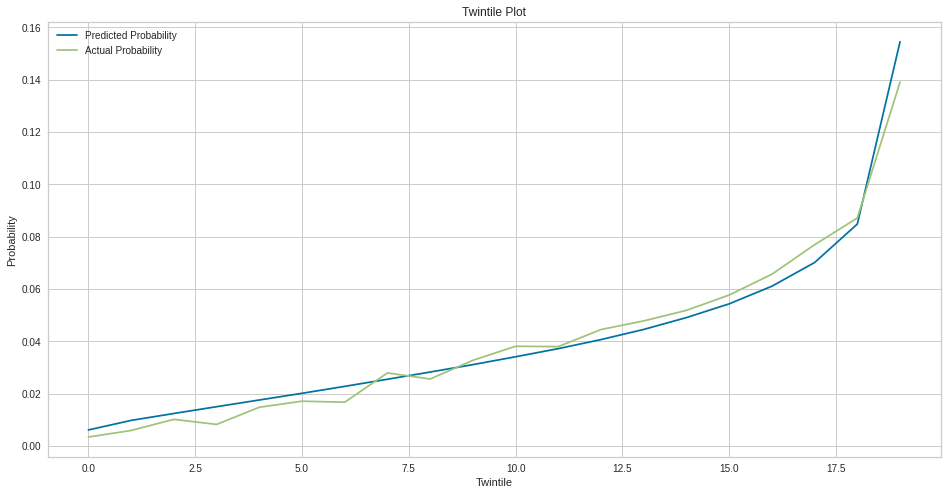

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(16,8))
plt.plot(twintiles.y_pred['mean'])
plt.plot(twintiles.funded_flag['mean'])
plt.title('Twintile Plot')
plt.ylabel('Probability')
plt.xlabel('Twintile')
plt.legend(['Predicted Probability', 'Actual Probability'], loc='upper left')
plt.show()

In [ ]:
model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model.score(X_test, y_test)

0.6458142561087281

In [ ]:
# Set classes for all plots
classes = ['Win', 'Lose']
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(log_model, classes=classes)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()   

In [ ]:
# wall-clock time at beginning of modeling work
start_time = time.clock()  

classifier = LogisticRegression()
classifier.fit(X_train, y_train)  
# evaluate on the test set for this fold
y_final_test_logit_predict_prob = classifier.predict_proba(X_test)
y_final_test_logit_predict = classifier.predict(X_test)

print('Area under ROC curve:', roc_auc_score(y_test, y_final_test_logit_predict_prob[:,1]))

print('\nLogistic Regression Confusion Matrix',
      '(rows actual, columns predicted)\n')
print_cm(confusion_matrix(y_test.values, 
                 y_final_test_logit_predict),
                 labels = classes)

print('\nLogistic Regression Accuracy: ',                
np.round(accuracy_score(y_test.values, 
               y_final_test_logit_predict), decimals = 3))
          
print()

end_time = time.clock()  # wall-clock time at end of modeling work
runtime = end_time - start_time  # seconds of wall-clock time 
print('\nLogistic Regression classification elapsed time (seconds):', 
      np.round(runtime, decimals = 3))

print('\nRUN COMPLETE')    

## Save Model


In [ ]:
from sklearn.externals import joblib

# Save to file in the current working directory
joblib_file = "Fplus_Lead_Scoring"
joblib.dump(model1, joblib_file)

# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

['Fplus_Lead_Scoring']

In [ ]:
fplus_ls_model = joblib.load('Fplus_Lead_Scoring')

# Check API

In [ ]:
test = {"co_app_verifiable_annual_income":68000,"loan_use":'Other', \
        "employment_status":'Retired', "final_loan_amount":25000, "fico":645,\
        "lti":18.23, "xpn_bcc0300":11, "ndi_ratio":0.37523456, "utm_source":''}

In [ ]:
check_lead_phase1(test)

{'error': False,
 'return_lead': {'co_app_verifiable_annual_income': 68000,
  'employment_status': 'Retired',
  'fico': 645,
  'final_loan_amount': 25000,
  'loan_use': 'Other',
  'lti': 18.23,
  'ndi_ratio': 0.37523456,
  'utm_source': nan,
  'xpn_bcc0300': 11},
 'warning': 'Imputing values for: utm_source'}

In [ ]:
run(test)

['co_app' 'loan_use' 'mkt_chan' 'ficox' 'lti' 'bcc0300' 'employment_3'
 'loan_amount_4' 'ndi_3']
0.07341588521315365


[{'co_app_verifiable_annual_income': '68000',
  'employment_status': 'Retired',
  'fico': '645',
  'final_loan_amount': '25000',
  'fuse.error_flag': False,
  'fuse.error_reason': 'Imputing values for: utm_source ',
  'fuse.model': 'fplus_ls_202008_v1',
  'fuse.npv': 79.39927985802565,
  'fuse.score': 0.07341588521315365,
  'loan_use': 'Other',
  'lti': 18.23,
  'ndi_ratio': '0.37523456',
  'utm_source': '',
  'xpn_bcc0300': '11'}]

In [ ]:
lead = {"co_app_verifiable_annual_income":342,"loan_use":'Debt Consolidation', \
        "employment_status":'Full-time', "final_loan_amount":25000, "fico":700,\
        "lti":25.8, "xpn_bcc0300":42, "ndi_ratio":40, "utm_source":'Lending Tree'}
check_lead_phase1(lead)

{'error': False,
 'return_lead': {'co_app_verifiable_annual_income': 342,
  'employment_status': 'Full-time',
  'fico': 700,
  'final_loan_amount': 25000,
  'loan_use': 'Debt Consolidation',
  'lti': 25.8,
  'ndi_ratio': 40,
  'utm_source': 'Lending Tree',
  'xpn_bcc0300': 42},
 'warning': ''}

In [ ]:
run(lead)

['co_app' 'loan_use' 'mkt_chan' 'ficox' 'lti' 'bcc0300' 'employment_2'
 'loan_amount_4' 'ndi_1']
0.07068011014401647


[{'co_app_verifiable_annual_income': '342',
  'employment_status': 'Full-time',
  'fico': '700',
  'final_loan_amount': '25000',
  'fuse.error_flag': False,
  'fuse.error_reason': '',
  'fuse.model': 'fplus_ls_202008_v1',
  'fuse.npv': 76.4405391207538,
  'fuse.score': 0.07068011014401647,
  'loan_use': 'Debt Consolidation',
  'lti': 25.8,
  'ndi_ratio': '40',
  'utm_source': 'Lending Tree',
  'xpn_bcc0300': '42'}]

# Validation

### Load Data

In [ ]:
# Using GBQ shout Out to Hughes
import pandas_gbq
import pydata_google_auth

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=False)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=zRMFNc6WjpiVOFwTmpw6SEuRBAY71h&prompt=consent&access_type=offline
Enter the authorization code: 4/3AHVpf2DS6lmVg7TxNEajbnBMZjCCuOH7ab_22JhFNQxBX3wcPb05yk


In [ ]:
sql = """
SELECT
   m.name
  ,CAST(m.funded_flag AS INT64) AS funded_flag
  ,CAST(m.first_coapp AS INT64) AS first_coapp
  ,m.first_loan_use
  ,m.employment_status__c
  ,CAST(m.first_amount_of_loan_requested AS INT64) AS first_amount_of_loan_requested
  ,m.first_FICO
  ,m.First_LTI
  ,CAST(m.first_bcc0300__c AS INT64) AS first_bcc0300__c
  ,m.first_ndi_ratio__c
  ,m.utm_source__c
  ,a.original_npv_phase
  ,a.final_loan_amount
FROM
  `ffn-dw-bigquery-prd.Credit_Views.Check_Sales_NPV_Model_Inputs` m 
LEFT JOIN
  `ffam-data-platform.standardized_data.fplus_application` a on m.name = a.loan_id
WHERE
  createddate BETWEEN '2020-06-01' AND '2020-07-16'
  AND lead_type__c = 'Web'
ORDER BY 1
"""

In [ ]:
df = pandas_gbq.read_gbq(sql, project_id='ffn-dw-bigquery-prd', credentials=credentials, dialect='standard')


In [ ]:
df.head()

,name,funded_flag,first_coapp,first_loan_use,employment_status__c,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c,utm_source__c,original_npv_phase,final_loan_amount
0,App-07692220,0,0,Home Improvement,Full-time,30000.0,722.0,0.272727,12.0,0.3743956205591811,Lending Tree,63.43,30000.0
1,App-07692221,0,0,Other,Full-time,NaN,684.0,0.277778,NaN,0.3431510950139807,Lending Tree,43.51,25000.0
2,App-07692222,0,1,Home Improvement,Full-time,22000.0,745.0,0.144737,NaN,0.19591872845465313,Lending Tree,98.92,22000.0
3,App-07692223,0,0,Major Purchase,Full-time,NaN,712.0,0.363636,3.0,0.5409641010175394,ck,-3.62,11500.0
4,App-07692224,0,0,Credit Card Refinancing,Full-time,19000.0,686.0,0.275362,1.0,0.31619214618545377,Lending Tree,43.78,19000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50172 entries, 0 to 50171
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            50172 non-null  object 
 1   funded_flag                     50172 non-null  int64  
 2   first_coapp                     50172 non-null  int64  
 3   first_loan_use                  49423 non-null  object 
 4   employment_status__c            49442 non-null  object 
 5   first_amount_of_loan_requested  20173 non-null  float64
 6   first_FICO                      44076 non-null  object 
 7   First_LTI                       49436 non-null  float64
 8   first_bcc0300__c                17311 non-null  float64
 9   first_ndi_ratio__c              44073 non-null  object 
 10  utm_source__c                   49781 non-null  object 
 11  original_npv_phase              49438 non-null  float64
 12  final_loan_amount               

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37477 entries, 0 to 37476
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            37477 non-null  object 
 1   funded_flag                     37477 non-null  int64  
 2   first_coapp                     37477 non-null  int64  
 3   first_loan_use                  36867 non-null  object 
 4   employment_status__c            36885 non-null  object 
 5   first_amount_of_loan_requested  13936 non-null  float64
 6   first_FICO                      32747 non-null  float64
 7   First_LTI                       36881 non-null  float64
 8   first_bcc0300__c                12808 non-null  float64
 9   first_ndi_ratio__c              32754 non-null  object 
 10  utm_source__c                   37178 non-null  object 
 11  original_npv_phase              36882 non-null  float64
 12  final_loan_amount               

In [ ]:
#int(df['first_FICO'])
# convert column "a" of a DataFrame
df['first_FICO'] = pd.to_numeric(df['first_FICO'])

In [ ]:
df.isna().sum()

name                                  0
funded_flag                           0
first_coapp                           0
first_loan_use                      610
employment_status__c                592
first_amount_of_loan_requested    23541
first_FICO                         4730
First_LTI                           596
first_bcc0300__c                  24669
first_ndi_ratio__c                 4723
utm_source__c                       299
original_npv_phase                  595
final_loan_amount                    27
dtype: int64

In [ ]:
# percent of data that has funded or not
df1['funded_flag'].value_counts()/len(df1)

0    0.974251
1    0.025749
Name: funded_flag, dtype: float64

In [ ]:
# save full data
df1 = df

## Transform Data

In [ ]:
# Transform variables
df['co_app'] = df['first_coapp'].apply(get_co_app_cat)
df['loan_use'] = df['first_loan_use'].apply(get_loan_use_cat)
df['employment'] = df['employment_status__c'].apply(get_employment_cat)
df['loan_amount'] = df['first_amount_of_loan_requested'].apply(get_loan_amount_cat)
df['mkt_chan'] = df['utm_source__c'].apply(get_mkt_chan_cat)
df['ficox'] = df['first_FICO'].apply(get_fico)
df['lti'] = df['First_LTI'].apply(get_lti)
df['bcc0300'] = df['first_bcc0300__c'].apply(get_bcc0300)
df['ndi'] = df['first_ndi_ratio__c'].apply(get_ndi_cat)

In [ ]:
things = ['funded_flag', 'co_app', 'loan_use', 'mkt_chan', 'ficox', 'employment', 'lti', 'bcc0300', 'loan_amount', 'ndi']
val = df[things]
val.head()

,funded_flag,co_app,loan_use,mkt_chan,ficox,employment,lti,bcc0300,loan_amount,ndi
0,0,0,0,148.413159,0.500325,2,25.0,99,5,2
1,0,1,0,148.413159,0.500357,2,30.0,99,4,3
2,0,0,1,148.413159,0.500338,2,5.0,99,4,4
3,0,0,0,148.413159,0.500338,2,25.0,10,4,3
4,1,0,0,403.428793,0.500362,2,5.0,4,4,3


In [ ]:
# create dummies
cat_vars=['employment','loan_amount', 'ndi']
for var in cat_vars:
    cat_list = pd.get_dummies(val[var], prefix=var)
    temp=val.join(cat_list)
    val=temp
data_vars=val.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
val=val[to_keep]
print(val.columns.values)

# re-index to have same columns as the model
val = val.reindex(columns = ['funded_flag', 'ficox', 'lti', 'bcc0300', 'co_app',
                               'loan_use', 'employment_1',
                               'employment_2', 'employment_3', 'loan_amount_1',
                               'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 
                               'loan_amount_5', 'mkt_chan', 'ndi_1', 'ndi_2',
                               'ndi_3', 'ndi_4',], fill_value=0)

['funded_flag' 'co_app' 'loan_use' 'mkt_chan' 'ficox' 'lti' 'bcc0300'
 'employment_1' 'employment_2' 'employment_3' 'loan_amount_1'
 'loan_amount_2' 'loan_amount_3' 'loan_amount_4' 'loan_amount_5' 'ndi_1'
 'ndi_2' 'ndi_3' 'ndi_4']


In [ ]:
val.columns

Index(['funded_flag', 'ficox', 'lti', 'bcc0300', 'co_app', 'loan_use',
       'employment_1', 'employment_2', 'employment_3', 'loan_amount_1',
       'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 'loan_amount_5',
       'mkt_chan', 'ndi_1', 'ndi_2', 'ndi_3', 'ndi_4'],
      dtype='object')

In [ ]:
val.isna().sum()

funded_flag      0
ficox            0
lti              0
bcc0300          0
co_app           0
loan_use         0
employment_1     0
employment_2     0
employment_3     0
loan_amount_1    0
loan_amount_2    0
loan_amount_3    0
loan_amount_4    0
loan_amount_5    0
mkt_chan         0
ndi_1            0
ndi_2            0
ndi_3            0
ndi_4            0
dtype: int64

In [ ]:
val.describe()

,funded_flag,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4
count,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000,37477.000000
mean,0.025749,0.500344,19.330378,67.953918,0.203325,0.192571,0.104010,0.871228,0.024762,0.006564,0.039678,0.095392,0.208901,0.649465,139.035683,0.161326,0.140566,0.533180,0.164928
std,0.158388,0.000037,11.284676,43.198898,0.402477,0.394325,0.305278,0.334952,0.155401,0.080753,0.195203,0.293759,0.406529,0.477144,100.187161,0.367836,0.347578,0.498905,0.371120
min,0.000000,0.500278,0.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.389056,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500325,5.000000,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.598150,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.500352,20.000000,99.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,148.413159,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.500373,25.000000,99.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,148.413159,0.000000,0.000000,1.000000,0.000000
max,1.000000,0.500403,45.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,403.428793,1.000000,1.000000,1.000000,1.000000


## Predict

In [ ]:
val.drop(columns=['funded_flag'])

,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4
0,0.500325,25.0,99,0,0,0,1,0,0,0,0,0,1,148.413159,0,1,0,0
1,0.500357,30.0,99,1,0,0,1,0,0,0,0,1,0,148.413159,0,0,1,0
2,0.500338,5.0,99,0,1,0,1,0,0,0,0,1,0,148.413159,0,0,0,1
3,0.500338,25.0,10,0,0,0,1,0,0,0,0,1,0,148.413159,0,0,1,0
4,0.500362,5.0,4,0,0,0,1,0,0,0,0,1,0,403.428793,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37472,0.500329,25.0,16,0,0,0,1,0,0,0,0,0,1,148.413159,0,0,1,0
37473,0.500362,5.0,30,0,0,0,1,0,0,0,0,0,1,148.413159,0,1,0,0
37474,0.500352,5.0,99,1,1,1,0,0,0,0,0,0,1,148.413159,0,0,0,1
37475,0.500278,45.0,99,0,0,1,0,0,0,0,0,0,1,403.428793,1,0,0,0


In [ ]:
preds = fplus_ls_model.predict_proba(val.drop(columns=['funded_flag']))[:,1]

In [ ]:
val['pred'] = preds

In [ ]:
val['test_fund'] = df['funded_flag']

In [ ]:
sum(val['funded_flag'] == df['funded_flag'])

37477

In [ ]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37477 entries, 0 to 37476
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   funded_flag    37477 non-null  int64  
 1   ficox          37477 non-null  float64
 2   lti            37477 non-null  float64
 3   bcc0300        37477 non-null  int64  
 4   co_app         37477 non-null  int64  
 5   loan_use       37477 non-null  int64  
 6   employment_1   37477 non-null  uint8  
 7   employment_2   37477 non-null  uint8  
 8   employment_3   37477 non-null  uint8  
 9   loan_amount_1  37477 non-null  uint8  
 10  loan_amount_2  37477 non-null  uint8  
 11  loan_amount_3  37477 non-null  uint8  
 12  loan_amount_4  37477 non-null  uint8  
 13  loan_amount_5  37477 non-null  uint8  
 14  mkt_chan       37477 non-null  float64
 15  ndi_1          37477 non-null  uint8  
 16  ndi_2          37477 non-null  uint8  
 17  ndi_3          37477 non-null  uint8  
 18  ndi_4 

In [ ]:
df['pred'] = preds

In [ ]:
df.head()

,name,funded_flag,first_coapp,first_loan_use,employment_status__c,first_amount_of_loan_requested,first_FICO,First_LTI,first_bcc0300__c,first_ndi_ratio__c,utm_source__c,original_npv_phase,final_loan_amount,co_app,loan_use,employment,loan_amount,mkt_chan,ficox,lti,bcc0300,ndi,pred
0,App-07725757,0,0,Moving Expenses,Full-time,NaN,777.0,0.250000,NaN,0.5163459855125826,Lending Tree,43.08,20000.0,0,0,2,5,148.413159,0.500325,25.0,99,2,0.000998
1,App-07725758,0,1,Debt Consolidation,Full-time,28000.0,705.0,0.304348,NaN,0.3839864211079504,Lending Tree,124.85,28000.0,1,0,2,4,148.413159,0.500357,30.0,99,3,0.001958
2,App-07725759,0,0,Other,Full-time,20000.0,742.0,0.133333,NaN,0.20666452560671075,Lending Tree,20.61,20000.0,0,1,2,4,148.413159,0.500338,5.0,99,4,0.001416
3,App-07725763,0,0,Credit Card Refinancing,Full-time,25652.0,740.0,0.288225,10.0,0.40283870907599095,Lending Tree,55.85,25652.0,0,0,2,4,148.413159,0.500338,25.0,10,3,0.033369
4,App-07725764,1,0,Debt Consolidation,Full-time,20000.0,692.0,0.142857,4.0,0.4197147180147965,ck,146.50,14999.0,0,0,2,4,403.428793,0.500362,5.0,4,3,0.222773


In [ ]:
df.to_csv("validation.csv")

# Re-Train Model AGAIN!! hopefully last time

In [ ]:
# Using GBQ shout Out to Hughes
import pandas_gbq
import pydata_google_auth

SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=False)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=Vjt9KRIw8c76gwe3u1dLeDylXMUDhS&prompt=consent&access_type=offline
Enter the authorization code: 4/3AFzYHKUhFsTMfHRHyIyn-bdxc0Mfldd9gZtT2omGg9zsQ8nMS85Exw


In [ ]:
sql = """
SELECT 
 loan_id
, CASE WHEN funded_date IS NOT NULL THEN 1 ELSE 0 END AS funded_flag
, co_app_verifiable_annual_income
, loan_use
, employment_status
, amount_of_loan_requested
, fico
, lti
, bcc0300
, ndi_ratio
, utm_source
, original_npv_phase
, final_loan_amount

FROM `ffam-data-platform.standardized_data.fplus_application` 
WHERE flag_eligible_lead = true
AND latest_prequal_decision <> 'DECLINED'
AND created_datetime BETWEEN '2020-03-01' AND '2020-06-15'
"""

In [ ]:
df1 = pandas_gbq.read_gbq(sql, project_id='ffn-dw-bigquery-prd', credentials=credentials, dialect='standard')

df = df1

In [ ]:
# Transform variables
df['co_app'] = df['co_app_verifiable_annual_income'].apply(get_co_app_cat)
df['loan_use'] = df['loan_use'].apply(get_loan_use_cat)
df['employment'] = df['employment_status'].apply(get_employment_cat)
df['loan_amount'] = df['amount_of_loan_requested'].apply(get_loan_amount_cat)
df['mkt_chan'] = df['utm_source'].apply(get_mkt_chan_cat)
df['ficox'] = df['fico'].apply(get_fico)
df['lti'] = df['lti'].apply(get_lti)
df['bcc0300'] = df['bcc0300'].apply(get_bcc0300)
df['ndi'] = df['ndi_ratio'].apply(get_ndi_cat)

In [ ]:
things = ['co_app', 'loan_use', 'mkt_chan', 'ficox', 'employment', 'lti', 'bcc0300', 'loan_amount', 'ndi']
train = df[things]
train.head()

,co_app,loan_use,mkt_chan,ficox,employment,lti,bcc0300,loan_amount,ndi
0,0,0,148.413159,0.500379,2,45.0,30,5,1
1,0,0,148.413159,0.500352,2,45.0,18,4,1
2,0,0,148.413159,0.500385,2,45.0,15,5,1
3,1,0,148.413159,0.500357,2,45.0,3,1,1
4,0,0,148.413159,0.500373,2,45.0,13,4,1


In [ ]:
train.describe()

,co_app,loan_use,mkt_chan,ficox,employment,lti,bcc0300,loan_amount,ndi
count,88679.000000,88679.000000,88679.000000,88679.000000,88679.000000,88679.000000,88679.000000,88679.000000,88679.000000
mean,0.213647,0.153148,147.530966,0.500350,1.914140,44.955179,8.099900,3.457786,1.003687
std,0.409883,0.360132,55.966390,0.000023,0.405123,1.169389,6.718687,0.907428,0.089340
min,0.000000,0.000000,2.718282,0.500278,1.000000,0.360000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,148.413159,0.500333,2.000000,45.000000,4.000000,3.000000,1.000000
50%,0.000000,0.000000,148.413159,0.500352,2.000000,45.000000,7.000000,4.000000,1.000000
75%,0.000000,0.000000,148.413159,0.500368,2.000000,45.000000,10.000000,4.000000,1.000000
max,1.000000,1.000000,403.428793,0.500403,3.000000,45.000000,99.000000,5.000000,4.000000


In [ ]:
# create dummies
cat_vars=['employment','loan_amount', 'ndi']
for var in cat_vars:
    cat_list = pd.get_dummies(train[var], prefix=var)
    temp=train.join(cat_list)
    train=temp
data_vars=train.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
train=train[to_keep]
print(train.columns.values)

# re-index to have same columns as the model
train = train.reindex(columns = ['ficox', 'lti', 'bcc0300', 'co_app',
                               'loan_use', 'employment_1',
                               'employment_2', 'employment_3', 'loan_amount_1',
                               'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 
                               'loan_amount_5', 'mkt_chan', 'ndi_1', 'ndi_2',
                               'ndi_3', 'ndi_4',], fill_value=0)

['co_app' 'loan_use' 'mkt_chan' 'ficox' 'lti' 'bcc0300' 'employment_1'
 'employment_2' 'employment_3' 'loan_amount_1' 'loan_amount_2'
 'loan_amount_3' 'loan_amount_4' 'loan_amount_5' 'ndi_1' 'ndi_2' 'ndi_3'
 'ndi_4']


In [ ]:
train.head()

,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4
0,0.500379,45.0,30,0,0,0,1,0,0,0,0,0,1,148.413159,1,0,0,0
1,0.500352,45.0,18,0,0,0,1,0,0,0,0,1,0,148.413159,1,0,0,0
2,0.500385,45.0,15,0,0,0,1,0,0,0,0,0,1,148.413159,1,0,0,0
3,0.500357,45.0,3,1,0,0,1,0,1,0,0,0,0,148.413159,1,0,0,0
4,0.500373,45.0,13,0,0,0,1,0,0,0,0,1,0,148.413159,1,0,0,0


In [ ]:
all_train = df
all_train.head()

,loan_id,funded_flag,co_app_verifiable_annual_income,loan_use,employment_status,amount_of_loan_requested,fico,lti,bcc0300,ndi_ratio,utm_source,original_npv_phase,final_loan_amount,co_app,employment,loan_amount,mkt_chan,ficox,ndi
0,App-07341660,0,NaN,0,Full-time,83000.0,662.0,45.0,30,48.845654,loanhunch,139.71,40000.0,0,2,5,148.413159,0.500379,1
1,App-07300458,0,NaN,0,Full-time,33000.0,710.0,45.0,18,48.500000,loanhunch,14.03,18400.0,0,2,4,148.413159,0.500352,1
2,App-07325613,0,NaN,0,Full-time,89000.0,656.0,45.0,15,48.900000,loanhunch,444.61,40000.0,0,2,5,148.413159,0.500385,1
3,App-07574943,0,60000.0,0,Full-time,9000.0,709.0,45.0,3,38.700000,203,-0.57,9000.0,1,2,1,148.413159,0.500357,1
4,App-07326271,0,NaN,0,Full-time,33000.0,679.0,45.0,13,15.900000,loanhunch,46.27,33000.0,0,2,4,148.413159,0.500373,1


In [ ]:
all_train.describe()

,funded_flag,co_app_verifiable_annual_income,loan_use,amount_of_loan_requested,fico,lti,bcc0300,ndi_ratio,original_npv_phase,final_loan_amount,co_app,employment,loan_amount,mkt_chan,ficox,ndi
count,88679.000000,1.950600e+04,88679.000000,88679.000000,88487.000000,88679.000000,88679.000000,88476.000000,88674.000000,88679.000000,88679.000000,88679.000000,88679.000000,88679.000000,88679.000000,88679.000000
mean,0.091093,7.558862e+04,0.153148,24160.583666,721.173890,44.955179,8.099900,37.492635,54.181196,22079.610628,0.213647,1.914140,3.457786,147.530966,0.500350,1.003687
std,0.287742,6.892449e+05,0.360132,12172.914138,77.796208,1.169389,6.718687,15.409112,82.046204,10175.451830,0.409883,0.405123,0.907428,55.966390,0.000023,0.089340
min,0.000000,0.000000e+00,0.000000,1500.000000,479.000000,0.360000,0.000000,0.000000,-309.970000,4.000000,0.000000,1.000000,1.000000,2.718282,0.500278,1.000000
25%,0.000000,4.000000e+04,0.000000,15000.000000,686.000000,45.000000,4.000000,27.100000,10.220000,14000.000000,0.000000,2.000000,3.000000,148.413159,0.500333,1.000000
50%,0.000000,6.000000e+04,0.000000,20000.000000,718.000000,45.000000,7.000000,35.900000,29.080000,20000.000000,0.000000,2.000000,4.000000,148.413159,0.500352,1.000000
75%,0.000000,8.500000e+04,0.000000,30000.000000,753.000000,45.000000,10.000000,46.300000,67.850000,30000.000000,0.000000,2.000000,4.000000,148.413159,0.500368,1.000000
max,1.000000,9.500000e+07,1.000000,300000.000000,9003.000000,45.000000,99.000000,998.300000,1244.250000,75000.000000,1.000000,3.000000,5.000000,403.428793,0.500403,4.000000


In [ ]:
# segment out the variable we are predicting from the rest of the data
y = all_train['funded_flag']
X = train
print(X.shape, y.shape)

(88679, 18) (88679,)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


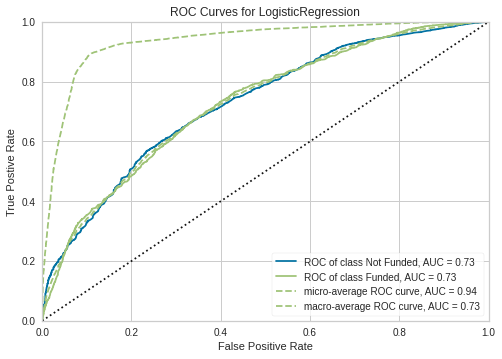

In [ ]:
# Set classes for all plots
classes = ['Not Funded', 'Funded']

classifier = LogisticRegression()

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(classifier, classes=classes)


visualizer.fit(X, y)  # Fit the training data to the visualizer
visualizer.score(val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

In [ ]:
model = LogisticRegression()
model.fit(X, y)
model.score(val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8918637574950034

In [ ]:
from sklearn.externals import joblib

# Save to file in the current working directory
joblib_file = "Fplus_Lead_Scoring_new"
joblib.dump(model, joblib_file)

['Fplus_Lead_Scoring_new']

In [ ]:
y_pred = model.predict(X)

In [ ]:
y_pred_prob = model.predict_proba(X)

In [ ]:
y_pred_prob

array([[0.97826754, 0.02173246],
       [0.96115166, 0.03884834],
       [0.96257634, 0.03742366],
       ...,
       [0.96341956, 0.03658044],
       [0.95517901, 0.04482099],
       [0.82223689, 0.17776311]])

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
classes = ['Not Funded', 'Funded']

print(classification_report(y, y_pred, target_names=classes))

              precision    recall  f1-score   support

  Not Funded       0.91      1.00      0.95     80601
      Funded       0.47      0.02      0.03      8078

    accuracy                           0.91     88679
   macro avg       0.69      0.51      0.49     88679
weighted avg       0.87      0.91      0.87     88679



# Validation Round 2

In [ ]:
sql = """
SELECT 
 loan_id
, CASE WHEN funded_date IS NOT NULL THEN 1 ELSE 0 END AS funded_flag
, co_app_verifiable_annual_income
, loan_use
, employment_status
, amount_of_loan_requested
, fico
, lti
, bcc0300
, ndi_ratio
, utm_source
, original_npv_phase
, final_loan_amount

FROM `ffam-data-platform.standardized_data.fplus_application` 
WHERE flag_eligible_lead = true
AND latest_prequal_decision <> 'DECLINED'
AND created_datetime BETWEEN '2020-06-01' AND '2020-07-15'
"""

In [ ]:
df1 = pandas_gbq.read_gbq(sql, project_id='ffn-dw-bigquery-prd', credentials=credentials, dialect='standard')

df = df1

In [ ]:
# Transform variables
df['co_app'] = df['co_app_verifiable_annual_income'].apply(get_co_app_cat)
df['loan_use'] = df['loan_use'].apply(get_loan_use_cat)
df['employment'] = df['employment_status'].apply(get_employment_cat)
df['loan_amount'] = df['amount_of_loan_requested'].apply(get_loan_amount_cat)
df['mkt_chan'] = df['utm_source'].apply(get_mkt_chan_cat)
df['ficox'] = df['fico'].apply(get_fico)
df['lti'] = df['lti'].apply(get_lti)
df['bcc0300'] = df['bcc0300'].apply(get_bcc0300)
df['ndi'] = df['ndi_ratio'].apply(get_ndi_cat)

In [ ]:
things = ['co_app', 'loan_use', 'mkt_chan', 'ficox', 'employment', 'lti', 'bcc0300', 'loan_amount', 'ndi']
val = df[things]
val.head()

,co_app,loan_use,mkt_chan,ficox,employment,lti,bcc0300,loan_amount,ndi
0,1,0,148.413159,0.500357,3,45.0,1,4,1
1,1,0,148.413159,0.500333,2,45.0,6,3,1
2,0,0,148.413159,0.500338,2,45.0,3,3,1
3,1,0,148.413159,0.500391,2,45.0,8,3,1
4,0,0,148.413159,0.500357,2,45.0,6,3,1


In [ ]:
# create dummies
cat_vars=['employment','loan_amount', 'ndi']
for var in cat_vars:
    cat_list = pd.get_dummies(val[var], prefix=var)
    temp=val.join(cat_list)
    val=temp
data_vars=val.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
val=val[to_keep]
print(val.columns.values)

# re-index to have same columns as the model
val = val.reindex(columns = ['ficox', 'lti', 'bcc0300', 'co_app',
                             'loan_use', 'employment_1',
                             'employment_2', 'employment_3', 'loan_amount_1',
                             'loan_amount_2', 'loan_amount_3', 'loan_amount_4', 
                             'loan_amount_5', 'mkt_chan', 'ndi_1', 'ndi_2',
                             'ndi_3', 'ndi_4',], fill_value=0)

['co_app' 'loan_use' 'mkt_chan' 'ficox' 'lti' 'bcc0300' 'employment_1'
 'employment_2' 'employment_3' 'loan_amount_1' 'loan_amount_2'
 'loan_amount_3' 'loan_amount_4' 'loan_amount_5' 'ndi_1' 'ndi_2' 'ndi_3'
 'ndi_4']


In [ ]:
# preds = model.predict_proba(val)[:,1]
preds = fplus_ls_model.predict_proba(val)[:,1]

In [ ]:
df['pred'] = preds

In [ ]:
df

,loan_id,funded_flag,co_app_verifiable_annual_income,loan_use,employment_status,amount_of_loan_requested,fico,lti,bcc0300,ndi_ratio,utm_source,original_npv_phase,final_loan_amount,co_app,employment,loan_amount,mkt_chan,ficox,ndi,pred
0,App-07702283,0,48000.0,0,Retired,24351.84,704.0,45.0,1,51.800000,CS Phone,215.20000,7500.00,1,3,4,148.413159,0.500357,1,0.298968
1,App-07786402,0,17000.0,0,Full-time,19999.00,751.0,45.0,6,53.000000,CS Phone,114.23000,11999.00,1,2,3,148.413159,0.500333,1,0.261223
2,App-07777006,1,NaN,0,Full-time,15400.00,744.0,45.0,3,35.900000,aff_firstchoice,16.07000,16510.34,0,2,3,148.413159,0.500338,1,0.118408
3,App-07735283,1,36000.0,0,Full-time,15176.09,640.0,45.0,8,34.400000,CS Phone,115.07000,15200.38,1,2,3,148.413159,0.500391,1,0.247080
4,App-07794753,1,NaN,0,Full-time,12778.65,700.0,45.0,6,38.399467,CS Phone,27.86328,12705.01,0,2,3,148.413159,0.500357,1,0.107213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24018,App-07783306,0,85000.0,0,Full-time,45000.00,761.0,45.0,8,26.400000,Lending Tree,142.59000,40000.00,1,2,4,148.413159,0.500329,1,0.147362
24019,App-07759955,0,40000.0,0,Full-time,45000.00,772.0,45.0,4,31.600000,Lending Tree,130.60000,40000.00,1,2,4,148.413159,0.500325,1,0.167117
24020,App-07767242,0,NaN,0,Full-time,45000.00,798.0,45.0,6,37.400000,Lending Tree,83.63000,40000.00,0,2,4,148.413159,0.500316,1,0.059483
24021,App-07794988,0,110000.0,1,Full-time,45000.00,798.0,45.0,3,36.351241,Lending Tree,258.39000,40000.00,1,2,4,148.413159,0.500316,1,0.058089


In [ ]:
y_val = df['funded_flag']

## Twin

In [ ]:
# add deciles to the predictions
df['lead_scoring_twentile']=pd.qcut(df['pred'], 20, labels=False)

In [ ]:
twintiles = df.groupby(
    'lead_scoring_twentile'
).agg(
    {
        # Get the min, max, and mean of the predictions
		# min and max will help you see the boundaries of each decile
        'pred': [min, max, "count", "mean"],
        # Get the mean of the actuals
        'funded_flag': ["mean"],
    }
)

In [ ]:
twintiles

pred                           funded_flag
                            min       max count      mean        mean
lead_scoring_twentile                                                
0                      0.000352  0.014168  1202  0.009156    0.009983
1                      0.014168  0.019779  1202  0.016852    0.011647
2                      0.019779  0.032392  1200  0.024985    0.025000
3                      0.032392  0.040266  1203  0.036763    0.053200
4                      0.040266  0.046446  1202  0.043515    0.054908
5                      0.046446  0.049865  1217  0.048292    0.058340
6                      0.049865  0.053521  1183  0.052211    0.062553
7                      0.053521  0.057430  1222  0.056087    0.067921
8                      0.057430  0.061605  1212  0.059453    0.064356
9                      0.061605  0.066063  1181  0.063153    0.052498
10                     0.066063  0.081873  1189  0.071333    0.089151
11                     0.081873  0.100277  1206  0.091752    0.106136
12                     0.100277  0.109339  1196  0.104386    0.120401
13                     0.109616  0.118407  1227  0.113611    0.127954
14                     0.118407  0.129579  1179  0.123418    0.150975
15                     0.129579  0.146337  1199  0.137558    0.139283
16                     0.146338  0.161988  1205  0.152534    0.140249
17                     0.161988  0.191519  1196  0.171638    0.153846
18                     0.191519  0.276033  1203  0.244775    0.311721
19                     0.276033  0.712382  1199  0.357534    0.359466

In [ ]:
twintiles.to_csv("LeadScoringModel_Twintiles.csv", index=False)

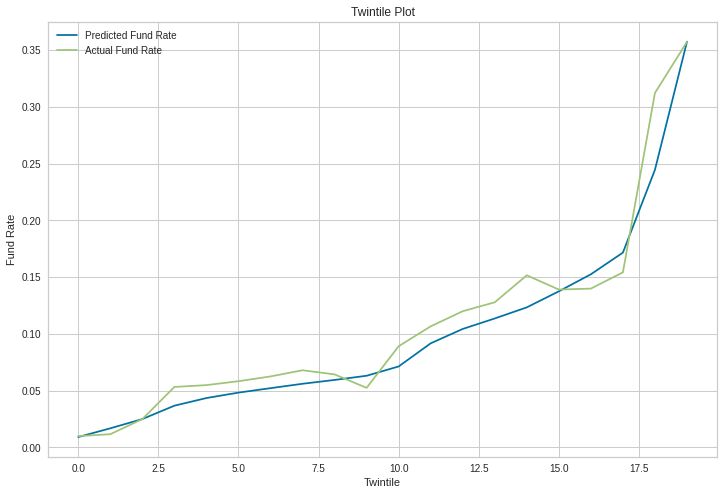

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,8))
plt.plot(twintiles.pred['mean'])
plt.plot(twintiles.funded_flag['mean'])
plt.title('Twintile Plot')
plt.ylabel('Fund Rate')
plt.xlabel('Twintile')
plt.legend(['Predicted Fund Rate', 'Actual Fund Rate'], loc='upper left')
plt.show()

In [ ]:
val

,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4
0,0.500368,45.0,11,0,0,0,1,0,0,0,0,1,0,403.428793,1,0,0,0
1,0.500357,45.0,9,0,0,0,1,0,1,0,0,0,0,403.428793,1,0,0,0
2,0.500368,45.0,10,0,0,1,0,0,0,0,0,1,0,403.428793,1,0,0,0
3,0.500368,45.0,10,0,0,0,1,0,0,0,1,0,0,148.413159,1,0,0,0
4,0.500316,45.0,14,0,0,0,1,0,0,0,0,0,1,148.413159,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24011,0.500312,45.0,4,0,1,0,1,0,0,0,0,1,0,148.413159,1,0,0,0
24012,0.500333,45.0,15,0,0,0,1,0,0,0,0,1,0,148.413159,1,0,0,0
24013,0.500316,45.0,5,1,0,0,1,0,0,0,0,1,0,148.413159,1,0,0,0
24014,0.500342,45.0,4,0,0,0,1,0,0,0,0,1,0,148.413159,1,0,0,0


In [ ]:
df

,loan_id,funded_flag,co_app_verifiable_annual_income,loan_use,employment_status,amount_of_loan_requested,fico,lti,bcc0300,ndi_ratio,utm_source,original_npv_phase,final_loan_amount,co_app,employment,loan_amount,mkt_chan,ficox,ndi,pred,twintile_rank
0,App-07709226,0,NaN,0,Full-time,27500.0,687.0,45.0,11,47.000000,ck,91.94,14999.0,0,2,4,403.428793,0.500368,1,0.037411,3
1,App-07697351,1,NaN,0,Full-time,9500.0,706.0,45.0,9,24.700000,ck,-27.32,9500.0,0,2,1,403.428793,0.500357,1,0.189823,17
2,App-07761663,0,NaN,0,Self-employed,22500.0,684.0,45.0,10,60.700000,ck,5.40,17500.0,0,1,4,403.428793,0.500368,1,0.009664,0
3,App-07778588,0,NaN,0,Full-time,17850.0,689.0,45.0,10,53.300000,FDR,13.79,17850.0,0,2,3,148.413159,0.500368,1,0.093742,11
4,App-07726194,0,NaN,0,Full-time,38000.0,797.0,45.0,14,40.900000,FDR,23.56,15000.0,0,2,5,148.413159,0.500316,1,0.038791,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24011,App-07761668,0,NaN,1,Full-time,45000.0,808.0,45.0,4,27.200000,Lending Tree,39.09,40000.0,0,2,4,148.413159,0.500312,1,0.019779,2
24012,App-07772833,0,NaN,0,Full-time,45000.0,751.0,45.0,15,46.700000,Lending Tree,100.36,40000.0,0,2,4,148.413159,0.500333,1,0.043251,4
24013,App-07728478,0,65000.0,0,Full-time,45000.0,798.0,45.0,5,26.700000,Lending Tree,123.79,40000.0,1,2,4,148.413159,0.500316,1,0.161988,17
24014,App-07795078,0,NaN,0,Full-time,45000.0,731.0,45.0,4,39.080869,Lending Tree,125.79,40000.0,0,2,4,148.413159,0.500342,1,0.063798,9


## NPV Values

In [ ]:
def npv_calc(x):

    loan_amt = x['amount_of_loan_requested']
    prob_prediction = x['pred']
    utm_source = x['utm_source']
    
    if pd.notnull(utm_source):
        utm_src = utm_source.strip()
        utm_src = utm_src.lower()
    
    npv = 0
    cpa = 0
    
    if pd.notnull(utm_source) and (utm_src in set(unitEconomicsData['utm_source'])):
        cpa = unitEconomicsData.loc[unitEconomicsData['utm_source'] == utm_src, 'CPA'].values[0]
                
    if pd.isnull(loan_amt):
        loan_amt = 0
    else:
        loan_amt = float(loan_amt) 
        
    npv = prob_prediction * ((loan_amt * 0.0681) - (621 + cpa))
    
    return npv


def npv_final_calc(x):

    loan_amt = x['final_loan_amount']
    prob_prediction = x['pred']
    utm_source = x['utm_source']
    
    if pd.notnull(utm_source):
        utm_src = utm_source.strip()
        utm_src = utm_src.lower()
    
    npv = 0
    cpa = 0
    
    if pd.notnull(utm_source) and (utm_src in set(unitEconomicsData['utm_source'])):
        cpa = unitEconomicsData.loc[unitEconomicsData['utm_source'] == utm_src, 'CPA'].values[0]
                
    if pd.isnull(loan_amt):
        loan_amt = 0
    else:
        loan_amt = float(loan_amt) 
        
    npv = prob_prediction * ((loan_amt * 0.0681) - (621 + cpa))
    
    return npv


def npv_actual_calc(x):

    loan_amt = x['final_loan_amount']
    utm_source = x['utm_source']
    fund = x['funded_flag']

    
    if pd.notnull(utm_source):
        utm_src = utm_source.strip()
        utm_src = utm_src.lower()
    
    npv = 0
    cpa = 0
    
    if pd.notnull(utm_source) and (utm_src in set(unitEconomicsData['utm_source'])):
        cpa = unitEconomicsData.loc[unitEconomicsData['utm_source'] == utm_src, 'CPA'].values[0]
                
    if pd.isnull(loan_amt):
        loan_amt = 0
    else:
        loan_amt = float(loan_amt) 
        
    npv = ((loan_amt * 0.0681) - (621 + cpa))

    if fund == 0:
        npv = 0
    
    return npv

In [ ]:
df['NPV'] = df.apply(npv_calc, axis=1)
df['NPV_final'] = df.apply(npv_final_calc, axis=1)
df['Actual_NPV'] = df.apply(npv_actual_calc, axis=1)
df['Delta_NPV'] = df['NPV'] - df['original_npv_phase']

In [ ]:
df.head()

,loan_id,funded_flag,co_app_verifiable_annual_income,loan_use,employment_status,amount_of_loan_requested,fico,lti,bcc0300,ndi_ratio,utm_source,original_npv_phase,final_loan_amount,co_app,employment,loan_amount,mkt_chan,ficox,ndi,pred,lead_scoring_twentile,NPV,NPV_final,Actual_NPV,Delta_NPV
0,App-07702283,0,48000.0,0,Retired,24351.84,704.0,45.0,1,51.800000,CS Phone,215.20000,7500.00,1,3,4,148.413159,0.500357,1,0.298968,19,310.137792,-32.961249,0.000000,94.937792
1,App-07786402,0,17000.0,0,Full-time,19999.00,751.0,45.0,6,53.000000,CS Phone,114.23000,11999.00,1,2,3,148.413159,0.500333,1,0.261223,18,193.548752,51.234242,0.000000,79.318752
2,App-07777006,1,NaN,0,Full-time,15400.00,744.0,45.0,3,35.900000,aff_firstchoice,16.07000,16510.34,0,2,3,148.413159,0.500338,1,0.118408,14,50.647626,59.600910,503.354154,34.577626
3,App-07735283,1,36000.0,0,Full-time,15176.09,640.0,45.0,8,34.400000,CS Phone,115.07000,15200.38,1,2,3,148.413159,0.500391,1,0.247080,18,101.918630,102.327338,414.145878,-13.151370
4,App-07794753,1,NaN,0,Full-time,12778.65,700.0,45.0,6,38.399467,CS Phone,27.86328,12705.01,0,2,3,148.413159,0.500357,1,0.107213,12,26.720239,26.182579,244.211181,-1.143041


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24016 entries, 0 to 24015
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   loan_id                          24016 non-null  object 
 1   funded_flag                      24016 non-null  int64  
 2   co_app_verifiable_annual_income  6874 non-null   float64
 3   loan_use                         24016 non-null  int64  
 4   employment_status                24015 non-null  object 
 5   amount_of_loan_requested         24016 non-null  float64
 6   fico                             23924 non-null  float64
 7   lti                              24016 non-null  float64
 8   bcc0300                          24016 non-null  int64  
 9   ndi_ratio                        23917 non-null  float64
 10  utm_source                       24016 non-null  object 
 11  original_npv_phase               24015 non-null  float64
 12  final_loan_amount 

In [ ]:
df.to_csv("Updated_NPV_Validation.csv", index=False)

In [ ]:
df

NameError: ignored

## NPV Twin

In [ ]:
# add deciles to the predictions
df['npv_twentile']=pd.qcut(df['NPV'], 20, labels=False)

In [ ]:
npv_twentile = df.groupby(
    'npv_twentile'
).agg(
    {
        # Get the min, max, and mean of the predictions
		# min and max will help you see the boundaries of each decile
        'NPV': [min, max, "count", "mean"],
        'original_npv_phase': ["mean"],
         # Get the mean of the actuals
        'Actual_NPV': ["mean"],
    }
)

In [ ]:
npv_twentile

NPV               ... original_npv_phase  Actual_NPV
                     min          max  ...               mean        mean
npv_twentile                           ...                               
0            -244.150247     2.662242  ...         -26.078169    2.397299
1               2.668925     8.211232  ...          10.539010   11.337612
2               8.218879    12.756662  ...          15.971179   14.240965
3              12.756669    17.538383  ...          24.409507   20.482934
4              17.538395    23.105719  ...          30.518046   23.019533
5              23.105725    30.313923  ...          31.385135   39.961917
6              30.350412    37.268605  ...          42.252747   42.075194
7              37.268630    42.080559  ...          46.721212   41.136171
8              42.082088    45.884384  ...          49.857984   42.632900
9              45.884394    50.404104  ...          50.773021   39.240994
10             50.404114    56.229534  ...          55.138607   53.997132
11             56.229560    63.549269  ...          61.186018   53.401844
12             63.549295    70.907786  ...          61.047369   45.527066
13             70.907800    81.665426  ...          72.252704   74.654401
14             81.665442    97.268614  ...          88.885089   82.451266
15             97.268634   118.948867  ...          96.607412  107.313205
16            118.960169   140.786009  ...         111.499844   94.796152
17            140.853139   175.189891  ...         124.618952  107.582015
18            175.189924   251.240639  ...         174.242813  163.898092
19            251.240750  3518.396241  ...         204.433840  210.970351

[20 rows x 6 columns]

In [ ]:
npv_twentile.to_csv("Updated_NPV_Twintiles.csv", index=False)

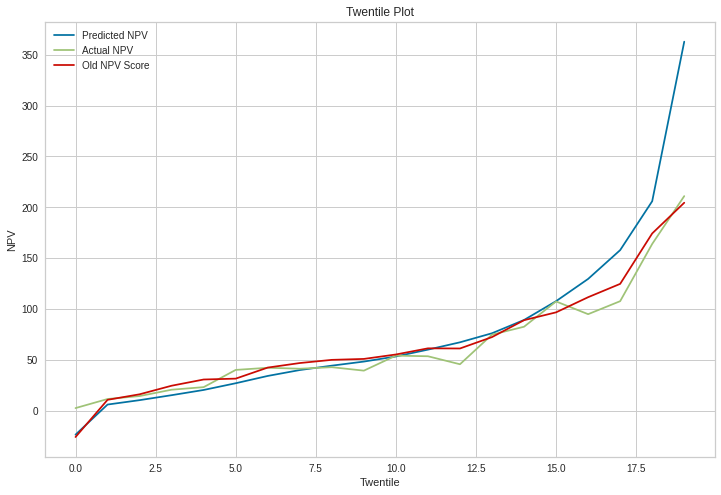

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,8))
plt.plot(npv_twentile.NPV['mean'])
plt.plot(npv_twentile.Actual_NPV['mean'])
plt.plot(npv_twentile.original_npv_phase['mean'])
plt.title('Twentile Plot')
plt.ylabel('NPV')
plt.xlabel('Twentile')
plt.legend(['Predicted NPV', 'Actual NPV', 'Old NPV Score'], loc='upper left')
plt.show()

In [ ]:
val

,ficox,lti,bcc0300,co_app,loan_use,employment_1,employment_2,employment_3,loan_amount_1,loan_amount_2,loan_amount_3,loan_amount_4,loan_amount_5,mkt_chan,ndi_1,ndi_2,ndi_3,ndi_4
0,0.500368,45.0,11,0,0,0,1,0,0,0,0,1,0,403.428793,1,0,0,0
1,0.500357,45.0,9,0,0,0,1,0,1,0,0,0,0,403.428793,1,0,0,0
2,0.500368,45.0,10,0,0,1,0,0,0,0,0,1,0,403.428793,1,0,0,0
3,0.500368,45.0,10,0,0,0,1,0,0,0,1,0,0,148.413159,1,0,0,0
4,0.500316,45.0,14,0,0,0,1,0,0,0,0,0,1,148.413159,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24011,0.500312,45.0,4,0,1,0,1,0,0,0,0,1,0,148.413159,1,0,0,0
24012,0.500333,45.0,15,0,0,0,1,0,0,0,0,1,0,148.413159,1,0,0,0
24013,0.500316,45.0,5,1,0,0,1,0,0,0,0,1,0,148.413159,1,0,0,0
24014,0.500342,45.0,4,0,0,0,1,0,0,0,0,1,0,148.413159,1,0,0,0


In [ ]:
df

,loan_id,funded_flag,co_app_verifiable_annual_income,loan_use,employment_status,amount_of_loan_requested,fico,lti,bcc0300,ndi_ratio,utm_source,original_npv_phase,final_loan_amount,co_app,employment,loan_amount,mkt_chan,ficox,ndi,pred,twintile_rank
0,App-07709226,0,NaN,0,Full-time,27500.0,687.0,45.0,11,47.000000,ck,91.94,14999.0,0,2,4,403.428793,0.500368,1,0.037411,3
1,App-07697351,1,NaN,0,Full-time,9500.0,706.0,45.0,9,24.700000,ck,-27.32,9500.0,0,2,1,403.428793,0.500357,1,0.189823,17
2,App-07761663,0,NaN,0,Self-employed,22500.0,684.0,45.0,10,60.700000,ck,5.40,17500.0,0,1,4,403.428793,0.500368,1,0.009664,0
3,App-07778588,0,NaN,0,Full-time,17850.0,689.0,45.0,10,53.300000,FDR,13.79,17850.0,0,2,3,148.413159,0.500368,1,0.093742,11
4,App-07726194,0,NaN,0,Full-time,38000.0,797.0,45.0,14,40.900000,FDR,23.56,15000.0,0,2,5,148.413159,0.500316,1,0.038791,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24011,App-07761668,0,NaN,1,Full-time,45000.0,808.0,45.0,4,27.200000,Lending Tree,39.09,40000.0,0,2,4,148.413159,0.500312,1,0.019779,2
24012,App-07772833,0,NaN,0,Full-time,45000.0,751.0,45.0,15,46.700000,Lending Tree,100.36,40000.0,0,2,4,148.413159,0.500333,1,0.043251,4
24013,App-07728478,0,65000.0,0,Full-time,45000.0,798.0,45.0,5,26.700000,Lending Tree,123.79,40000.0,1,2,4,148.413159,0.500316,1,0.161988,17
24014,App-07795078,0,NaN,0,Full-time,45000.0,731.0,45.0,4,39.080869,Lending Tree,125.79,40000.0,0,2,4,148.413159,0.500342,1,0.063798,9
